In [23]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

fontpath = os.path.expanduser('~/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize": 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    #     'font.family': 'Linux Libertine Display',
    'text.usetex': False
}

mpl.rcParams.update(params)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import set_size

# Loads data
df_ts = pd.read_csv("../data/df_ts.csv.gz", compression="infer")
df_fc = pd.read_csv("../data/df_fc.csv", compression="infer")
df_casv = pd.read_csv("../data/df_casv.csv.gz", compression="infer")

# This transforms the data into date time
df_casv["date"] = pd.to_datetime(df_casv["date"])

# Creates helpers
country2code = dict(df_ts.groupby("country").first()["code"])
claim2kg = dict(df_casv.groupby("claim").first()["kg"])
countries = set(df_casv.country.values)
claims = set(df_casv.claim.values)
org2country = dict(pd.read_csv("../data/organizations.csv",
                               compression="infer").set_index("organization").country_org)
# Creates a value with the last_casv for each row
last_casv = df_casv.groupby(["claim", "country"]).last()
    .reset_index().rename({"casv": "last_casv"}, axis=1)
df_casv = df_casv.merge(last_casv[["claim", "country", "last_casv"]], how="left", left_on=["claim", "country"],
                        right_on=["claim", "country"])

# Normalizes casv relative to last_casv for each treshold
df_casv["casv_norm"] = None
th = 0.005
df_casv["th"] = df_casv["last_casv"] > th
df_casv.loc[df_casv.th, "casv_norm"] = df_casv.loc[df_casv.th, "casv"] / df_casv.loc[df_casv.th, "last_casv"]
df_casv["closest_sunday"] = df_casv["date"].apply(str)


In [3]:
# Creates a simplified dataframe for the fact-checking efforts

df = []
for idx, row in df_fc.iterrows():
    row = dict(row)
    countries_ = eval(row["countries_list"])
    for country in countries_:
        df.append(
            {
                "date": pd.to_datetime(row["date"]),
                "claim": row["claim"].replace(".csv", ""),
                "code": country2code[country],
                "country": country,
                "kg": claim2kg[row["claim"].replace(".csv", "")],
                "country_org": org2country[row["organization"]],
                "code_org": country2code[org2country[row["organization"]]]
            })

df_fc_p = pd.DataFrame(df)

# Closest sunday to match with FC
df_fc_p["closest_sunday"] = df_fc_p.date.apply(lambda x: x + pd.offsets.Week(weekday=6) if x.weekday() >= 3
else x - pd.offsets.Week(weekday=6))
df_fc_p["closest_sunday"] = df_fc_p["closest_sunday"].apply(str)

df_fc_p = df_fc_p.merge(df_casv, left_on=["claim", "country", "kg", "closest_sunday", "code"],
                        right_on=["claim", "country", "kg", "closest_sunday", "code"])

df_fc_p_org = df_fc_p.loc[df_fc_p.code == df_fc_p.code_org].copy(deep=True)

In [4]:
# Creates a simplified dataframe with everything we need for the analysis. For each country,claim pair we get the:
# - last_casv: value for casv in the end of 2020.
# - refv_norm: (the mean attention in 2019 normalized by the average google 2020 day).
# - fc: was the claim fact-checked into that country
# - fcn: how many times was it fact-checked?

df = []
for country in countries:
    #print(country)
    code = country2code[country]
    for claim in claims:
        tmp = df_casv.loc[(df_casv.code == code) & (df_casv.claim == claim), "last_casv"]
        tmp2 = df_fc_p[(df_fc_p.code == code) & (df_fc_p.claim == claim)]
        tmp4 = df_fc_p_org[(df_fc_p.code == code) & (df_fc_p.claim == claim)]
        tmp3 = df_casv.loc[(df_casv.code == code) & (df_casv.claim == claim), "refv_norm"]
        tmp5 = df_fc_p.loc[(df_fc_p.code == code) &
                           (df_fc_p.claim == claim)].sort_values("date_x").casv_norm.values
        tmp6 = df_fc_p_org.loc[(df_fc_p_org.code == code) &
                               (df_fc_p_org.claim == claim)].sort_values("date_x").casv_norm.values
        if len(tmp) > 0:
            df.append(
                {
                    "claim": claim,
                    "code": country2code[country],
                    "country": country,
                    "last_casv": tmp.values[0],
                    "kg": claim2kg[claim.replace(".csv", "")],
                    "fc": len(tmp2) > 0,
                    "fcn": len(tmp2),
                    "fc_org": len(tmp4) > 0,
                    "fcn_org": len(tmp4),
                    "refv_norm": tmp3.values[0],
                    "casv_norm_first": tmp5[0] if len(tmp5) > 0 else None,
                    "casv_norm_first_org": tmp6[0] if len(tmp6) > 0 else None
                })

df_casv_claim = pd.DataFrame(df).reset_index(drop=True)
df_casv_claim["th"] = df_casv_claim["last_casv"] > th
fc_per_country = dict(df_casv_claim.groupby("country").fc.sum())
fc_per_claim = dict(df_casv_claim.groupby("claim").fc.sum())
df_casv_claim["fc_per_country"] = df_casv_claim.country.apply(lambda x: fc_per_country[x])
df_casv_claim["fc_per_claim"] = df_casv_claim.claim.apply(lambda x: fc_per_claim[x])

/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [5]:
df_fc_p["fc_per_country"] = df_fc_p.country.apply(lambda x: fc_per_country[x])
df_fc_p_org["fc_per_country"] = df_fc_p_org.country.apply(lambda x: fc_per_country[x])

# Relevance

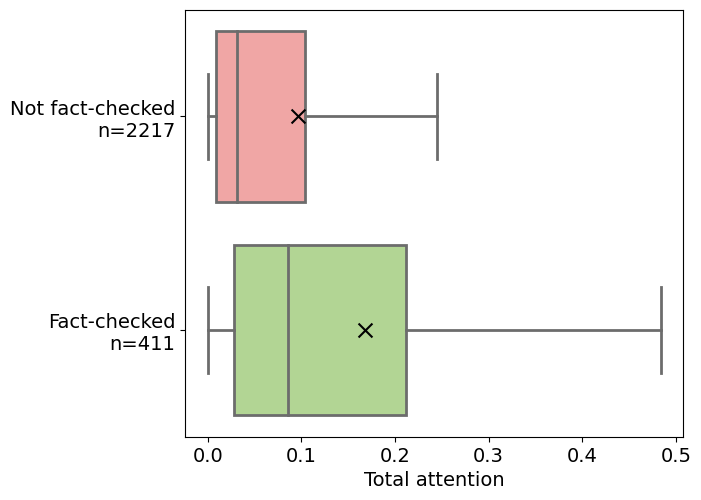

In [25]:
import scipy.stats

fig, ax = plt.subplots(1, figsize=(7, 5))

sns.boxplot(x="last_casv", y="fc", data=df_casv_claim, showfliers=False, ax=ax, orient="h", linewidth=2,
            palette=np.array(["#FC9A98", "#B1E089"]))
ax.set_ylabel("")
ax.set_yticklabels(["Not fact-checked\nn=" + str(len(df_casv_claim[~df_casv_claim.fc])),
                    "Fact-checked\nn=" + str(len(df_casv_claim[df_casv_claim.fc]))])

ax.set_xlabel("Total attention")

last_casv_nfc = df_casv_claim[~df_casv_claim.fc].last_casv
last_casv_fc = df_casv_claim[df_casv_claim.fc].last_casv
ax.scatter([last_casv_nfc.mean()], [0], color="black", marker="x", s=100)
ax.scatter([last_casv_fc.mean()], [1], color="black", marker="x", s=100)
set_size(fig, (7, 5))
plt.show()
fig.savefig('../images/relevance_1.pdf', bbox_inches='tight')

(-1, 0]
(0, 1]
(1, 5]
(5, 43]


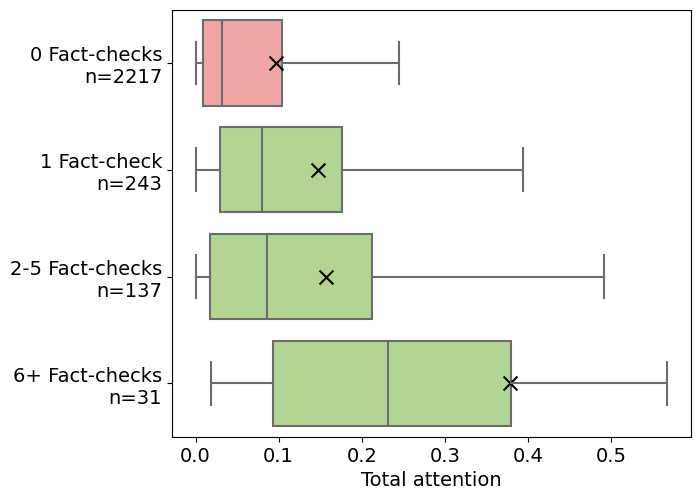

In [26]:
fig, ax = plt.subplots(1, figsize=(7, 5))

df_casv_claim["kbin"] = pd.cut(df_casv_claim["fcn"].astype(float).values, bins=(-1, 0, 1, 5, 43), right=True)

sns.boxplot(y="kbin", x="last_casv", data=df_casv_claim, showfliers=False,
            palette=np.array(["#FC9A98"] + ["#B1E089"] * 5), ax=ax)

acc = ["0 Fact-checks", "1 Fact-check", "2-5 Fact-checks", "6+ Fact-checks"]
for idx, kbin in enumerate(sorted(set(df_casv_claim["kbin"].values))):
    print(kbin)
    casv_kbin = df_casv_claim[df_casv_claim.kbin == kbin].last_casv
    ax.scatter([df_casv_claim[df_casv_claim.kbin == kbin].last_casv.mean()],
               [idx], color="black", marker="x", s=100)
    acc[idx] += "\nn=" + str(len(casv_kbin))

ax.set_ylabel("")

ax.set_yticklabels(acc)

ax.set_xlabel("Total attention")
set_size(fig, (7, 5))
plt.show()
fig.savefig('../images/relevance_2.pdf', bbox_inches='tight')


In [8]:
def get_top_k(df, k=3):
    fc = df[df.fc].sort_values("last_casv", ascending=False)
    nfc = df[~df.fc].sort_values("last_casv", ascending=False)

    if len(fc) < k or len(nfc) < k:
        return np.nan

    if k == 10:
        print(">", df.head(1)["country"].values[0])
        #         print(fc.head(k).claim.values)
        print(nfc.head(k).claim.values)
        print(nfc.head(k).last_casv.sum(), fc.head(k).last_casv.sum())

    return fc.head(k).last_casv.sum() / nfc.head(k).last_casv.sum()


import pandas as pd

df_strip = []
for k in range(1, 11):
    tmp = df_casv_claim.groupby(["code", "country"])
        .apply(lambda x: get_top_k(x, k))
        .reset_index()
        .rename({0: "last_casv"}, axis=1)
    tmp = tmp[~tmp.last_casv.isna()]
    tmp["k"] = str(k)
    print(k, len(tmp))

    df_strip.append(tmp)

df_strip = pd.concat(df_strip).dropna()
df_strip["last_casv_2"] = np.log2(df_strip["last_casv"])
df_strip["fc_per_country"] = df_strip["country"].apply(lambda x: fc_per_country[x])

1 70
2 57
3 45
4 39
5 35
6 27
7 22
8 19
9 17
> Argentina
['tea-cures' 'ivermectin-cures' 'bat-soup' 'simpsons-predicted'
 'hydroxychloroquine-cures' 'alcohol-cures' 'pope-francis-infected'
 'chloroquine-cures' 'azithromycin-cures' 'cannabis-cures']
2.1166865301711377 1.9370165415737177
> Brazil
['vitamind-cures' 'propolis-cures' 'dexamethasone-cures'
 '1981book-predicted' 'blood-types' 'cannabis-cures' 'ronaldo-hotels'
 'favipiravir-cures' 'infrared-damage' 'ketamine-cures']
0.7810558611410235 4.448500844290537
> Colombia
['tea-cures' 'vitamind-cures' 'pope-francis-infected' 'bat-soup'
 'vitaminc-cures' 'dexamethasone-cures' 'simpsons-predicted'
 'chloroquine-cures' 'favipiravir-cures' '1981book-predicted']
1.7220371179465364 2.087102334942706
> Spain
['tea-cures' 'blood-types' 'hydroxychloroquine-cures'
 'nostradamus-predicted' 'pope-francis-infected' 'chloroquine-cures'
 'ivermectin-cures' 'dexamethasone-cures' 'cannabis-cures'
 'azithromycin-cures']
1.3319742252857252 2.085002661789

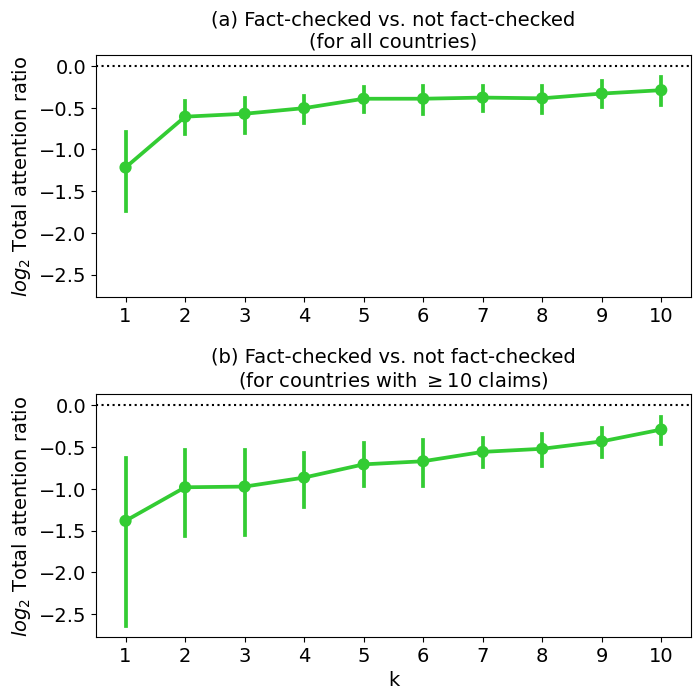

In [27]:
fig, axs = plt.subplots(2, figsize=(7, 7), sharey=True, gridspec_kw={"hspace": 0.4})
ax = axs[0]
g = sns.pointplot(y="last_casv_2", x="k", join=True, color="#33CC33",
                  data=df_strip, alpha=.25, zorder=2, ax=ax)

ax.set_ylabel(r'$log_2$ Total attention ratio')
ax.axhline(0, color="black", ls=":")
ax.set_title("(a) Fact-checked vs. not fact-checked\n(for all countries)")
ax.set_xlabel(r'')

ax = axs[1]

g = sns.pointplot(y="last_casv_2", x="k", join=True, color="#33CC33",
                  data=df_strip[df_strip.fc_per_country >= 10], alpha=.25, zorder=2, ax=ax)
ax.set_xlabel(r'k')
ax.set_ylabel(r'$log_2$ Total attention ratio')
ax.axhline(0, color="black", ls=":")
ax.set_title("(b) Fact-checked vs. not fact-checked\n(for countries with $\geq$10 claims)")

set_size(fig, (7, 7))
plt.show()
fig.savefig('../images/relevance_1a.pdf', bbox_inches='tight')

In [10]:
def get_top_k(df, k=3):
    allclaims = df.sort_values("last_casv", ascending=False)
    fc = df[df.fc].sort_values("last_casv", ascending=False)
    nfc = df[~df.fc].sort_values("last_casv", ascending=False)

    if len(fc) < k or len(nfc) < k:
        return np.nan

    return allclaims.head(k).fc.mean()


import pandas as pd

df_strip = []
for k in [10]:
    tmp = df_casv_claim.groupby(["code", "country"])
        .apply(lambda x: get_top_k(x, k))
        .reset_index()
        .rename({0: "last_casv"}, axis=1)
    tmp = tmp[~tmp.last_casv.isna()]
    tmp["k"] = str(k)
    print(k, len(tmp))

    df_strip.append(tmp)
df_strip = pd.concat(df_strip).dropna()
print(df_strip.reset_index().to_latex())


10 13
\begin{tabular}{lrllrl}
\toprule
{} &  index & code &        country &  last\_casv &   k \\
\midrule
0  &      0 &   AR &      Argentina &        0.5 &  10 \\
1  &      5 &   BR &         Brazil &        0.8 &  10 \\
2  &     13 &   CO &       Colombia &        0.6 &  10 \\
3  &     20 &   ES &          Spain &        0.7 &  10 \\
4  &     21 &   FR &         France &        0.6 &  10 \\
5  &     32 &   IN &          India &        0.7 &  10 \\
6  &     34 &   IT &          Italy &        0.5 &  10 \\
7  &     37 &   KE &          Kenya &        0.4 &  10 \\
8  &     48 &   MX &         Mexico &        0.7 &  10 \\
9  &     54 &   PH &    Philippines &        0.6 &  10 \\
10 &     56 &   PT &       Portugal &        0.5 &  10 \\
11 &     64 &   TR &         Turkey &        0.5 &  10 \\
12 &     68 &   US &  United States &        0.7 &  10 \\
\bottomrule
\end{tabular}



In [11]:
def get_top_k(df, k=3):
    fc = df[df.fc].sort_values("last_casv", ascending=False)
    nfc = df[df.fc].sort_values("fcn", ascending=False)

    if len(fc) < k or len(nfc) < k:
        return np.nan

    #     print(">", df.head(1)["country"].values[0])
    #     print(fc.head(k).claim.values)
    #     print(nfc.head(k).claim.values)

    #     print(nfc.head(k).last_casv.sum(), fc.head(k).last_casv.sum())

    return nfc.head(k).last_casv.sum() / fc.head(k).last_casv.sum()


import pandas as pd

df_strip = []
for k in range(1, 11):
    tmp = df_casv_claim.groupby(["code", "country"])
        .apply(lambda x: get_top_k(x, k))
        .reset_index()
        .rename({0: "last_casv"}, axis=1)
    tmp["k"] = str(k)
    df_strip.append(tmp)

df_strip = pd.concat(df_strip).dropna()
df_strip["last_casv_2"] = np.log2(df_strip["last_casv"])

df_strip["fc_per_country"] = df_strip["country"].apply(lambda x: fc_per_country[x])

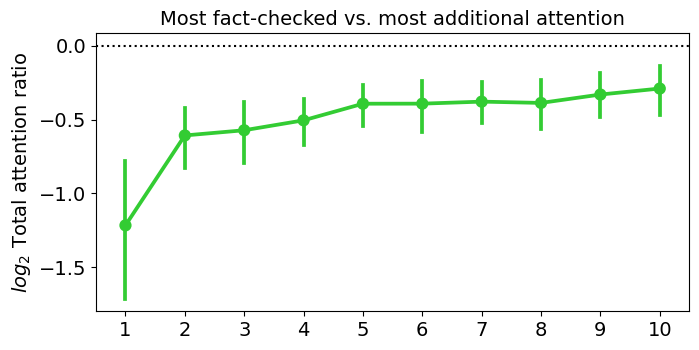

In [28]:
fig, ax = plt.subplots(1, figsize=(7, 3.5), sharey=True, gridspec_kw={"hspace": 0.4})
g = sns.pointplot(y="last_casv_2", x="k", join=True, color="#33CC33",
                  data=df_strip, alpha=.25, zorder=2, ax=ax)

ax.set_ylabel(r'$log_2$ Total attention ratio')
ax.axhline(0, color="black", ls=":")
ax.set_title("Most fact-checked vs. most additional attention")
ax.set_xlabel(r'')

set_size(fig, (7, 3.5))
plt.show()
fig.savefig('../images/relevance_2a.pdf', bbox_inches='tight')

## Speed

In [13]:
df_i = []
for idx, group in df_fc_p.sort_values(["claim", "code", "date_x"]).groupby(["claim", "code"]):
    is_ = list(range(len(group)))
    vs_ = group.casv_norm.values
    fc_per_country_ = group.fc_per_country.values
    for i, v, fc in zip(is_, vs_, fc_per_country_):
        df_i.append({"claim": idx[0], "code": idx[1], "k": i + 1, "casv_norm": v, "fc_per_country": fc})
df_i = pd.DataFrame(df_i)


In [14]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharex=True)

sns.pointplot(x="k", y="casv_norm", data=df_i[df_i.k < 11], color="#6666CC")
axs.axhline(0.5, color="black", ls=":")
axs.set_ylabel("% Additional Attention")
axs.set_title("% Additional attention before k-th fact-check")

axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
set_size(fig, (7, 4))
fig.savefig('../images/speed_1.pdf', bbox_inches='tight')

In [15]:
df_i[df_i.k == 1].casv_norm.sem()

0.012577250382901913

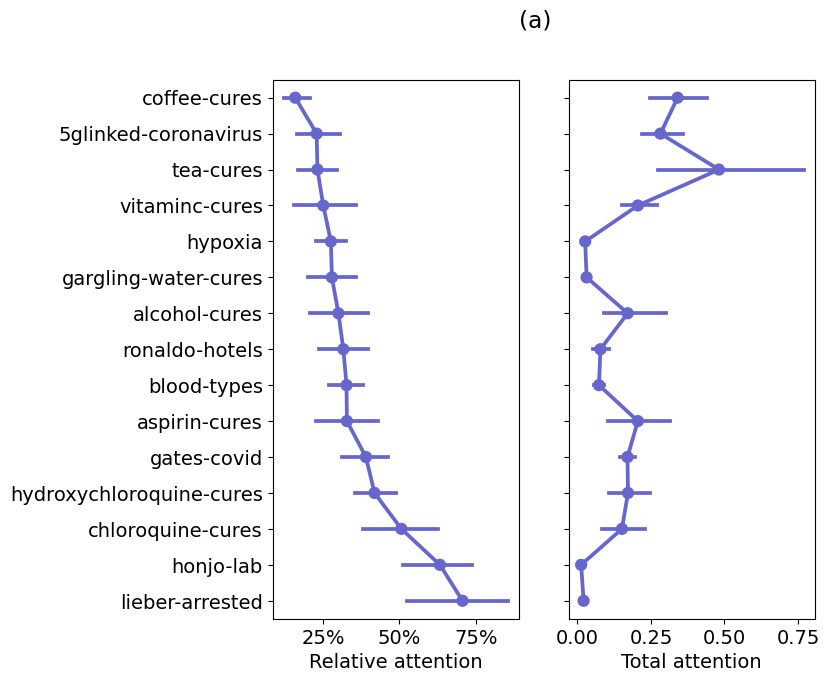

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7), sharey=True)

ax = axs[0]

tmp = df_casv_claim[(df_casv_claim.fc) &
                    (df_casv_claim.fc_per_claim >= 10)
                    ]
order = tmp.groupby("claim").casv_norm_first.mean().sort_values().index.values

sns.pointplot(x="casv_norm_first", y="claim", data=tmp, estimator=np.mean, order=order, color="#6666CC",
              ax=ax)

ax.set_ylabel(r'')
ax.set_xlabel("Relative attention")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax = axs[1]
sns.pointplot(x="last_casv", y="claim", data=tmp, estimator=np.mean, order=order, color="#6666CC",
              ax=ax)
ax.set_ylabel(r'')
ax.set_xlabel("Total attention")
fig.suptitle("(a)")
plt.show()
set_size(fig, (7, 5))
fig.savefig('../images/speed_2.pdf', bbox_inches='tight')

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model1 = ols('casv_norm_first ~ C(claim, Sum) + last_casv', data=tmp).fit()
model2 = ols('casv_norm_first ~ last_casv', data=tmp).fit()

anova_table = sm.stats.anova_lm(model2, model1)
anova_table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,289.0,16.098245,0.0,NaN,NaN,NaN
1,275.0,12.115125,14.0,3.983119,6.45803,3.046053e-11


In [18]:
import scipy.stats as stats

t = tmp[["claim", "casv_norm_first", "last_casv"]].dropna().groupby("claim").mean()
t
stats.spearmanr(t["casv_norm_first"], t["last_casv"])



SpearmanrResult(correlation=-0.6214285714285712, pvalue=0.013402006712181799)

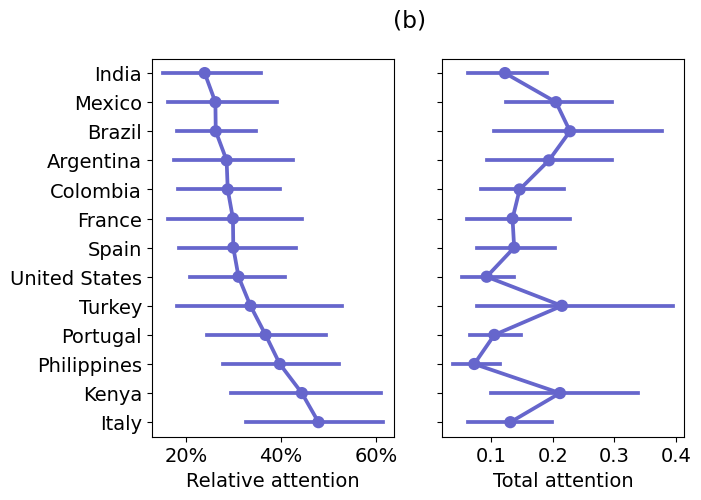

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7), sharey=True)

ax = axs[0]

tmp = df_casv_claim[(df_casv_claim.fc) &
                    (df_casv_claim.fc_per_country >= 10)
                    ]
order = tmp.groupby("country").casv_norm_first.mean().sort_values().index.values

sns.pointplot(x="casv_norm_first", y="country", data=tmp, estimator=np.mean, order=order, color="#6666CC",
              ax=ax)

ax.set_ylabel(r'')
ax.set_xlabel("Relative attention")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax = axs[1]
sns.pointplot(x="last_casv", y="country", data=tmp, estimator=np.mean, order=order, color="#6666CC",
              ax=ax)
ax.set_ylabel(r'')
ax.set_xlabel("Total attention")
fig.suptitle("(b)")

set_size(fig, (7, 5))
plt.show()
fig.savefig('../images/speed_3.pdf', bbox_inches='tight')

In [20]:
import scipy.stats as stats

t = tmp[["claim", "casv_norm_first", "last_casv"]].dropna().groupby("claim").mean()
t
stats.spearmanr(t["casv_norm_first"], t["last_casv"])



SpearmanrResult(correlation=-0.3324929971988796, pvalue=0.05099250313618478)

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model1 = ols('casv_norm_first ~ C(country, Sum) + last_casv', data=tmp).fit()
model2 = ols('casv_norm_first ~ last_casv', data=tmp).fit()

anova_table = sm.stats.anova_lm(model2, model1)
anova_table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,179.0,9.905488,0.0,NaN,NaN,NaN
1,167.0,9.150064,12.0,0.755424,1.148952,0.324344
